In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..

/home/rainorangelemon/Documents/tiny-diffusion


/home/rainorangelemon/micromamba/envs/robodiff/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import os
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
import torch as th
from scripts.best_of_n_on_sam_dataset import create_model_and_diffusion, CLEVRPosDataset, conditions_denoise_fn_factory
from baselines_clevr import make_estimate_neg_logp
from pathlib import Path
import numpy as np
from PIL import Image

/home/rainorangelemon/micromamba/envs/robodiff/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-07 21:52:40.471028: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/rainorangelemon/Documents/tiny-diffusion/scripts/best_of_n_on_sam_dataset.py:480: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="../conf")


In [7]:
with initialize(config_path="../conf", version_base="1.1"):
    cfg = compose(config_name="clevr_pos",
                  overrides=["num_constraints=5",
                             "experiment_name=test_simplified",
                             # "ckpt_path=ComposableDiff/models/ema_runpod_780000.pt",
                             # "model.noise_schedule=linear",
                            ])

In [8]:
# Setup
th.set_float32_matmul_precision('high')
th.set_grad_enabled(False)
has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

options = OmegaConf.to_container(cfg.model, resolve=True)

options["use_fp16"] = th.cuda.is_available()

model, diffusion = create_model_and_diffusion(**options)

model.eval()
if options['use_fp16']:
    model.convert_to_fp16()
model.to(device)

print(f'Loading checkpoint from {cfg.ckpt_path}')
checkpoint = th.load(cfg.ckpt_path, map_location='cpu')
model.load_state_dict(checkpoint)

print('Total base parameters', sum(x.numel() for x in model.parameters()))

# Create output directory
output_dir = Path(cfg.output_dir)
experiment_name = cfg.data_path.split('/')[-1].split('.')[0]
output_dir = output_dir / experiment_name
output_dir.mkdir(parents=True, exist_ok=True)

# Save the config
config_save_path = os.path.join(cfg.output_dir, "config.yaml")
with open(config_save_path, "w") as f:
    f.write(OmegaConf.to_yaml(cfg))

dataset = CLEVRPosDataset(data_path=cfg.data_path)

Loading checkpoint from ComposableDiff/models/clevr_pos.pt
Total base parameters 224779782


In [9]:
model = th.compile(model, mode="max-autotune")

/home/rainorangelemon/micromamba/envs/robodiff/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [10]:
from scripts.best_of_n_on_sam_dataset import add_noise_at_t, remove_noise_to_t

test_idx = 0
labels, _ = dataset[test_idx]

conditions_denoise_fn = conditions_denoise_fn_factory(model, th.tensor(labels[np.newaxis], dtype=th.float32),
                                                      batch_size=cfg.elbo.mini_batch, cfg=cfg)
estimate_neg_logp = make_estimate_neg_logp(elbo_cfg=cfg.elbo,
                                           noise_scheduler=diffusion,
                                           unconditioned_denoise_fn=conditions_denoise_fn[-1],
                                           progress=True)


def predict_noise(all_samples, condition_denoise_fn, noise, timesteps_t, k):
    timesteps_k = th.full((len(all_samples),), k, dtype=th.long, device=all_samples.device)
    noisy_x = add_noise_at_t(diffusion.base_diffusion, all_samples, noise, timesteps_t, timesteps_k)

        # check the predicted x0
    pred = condition_denoise_fn(noisy_x, timesteps_k)
    predicted_noise = pred[:, :3]
    model_var_values = pred[:, 3:]

        # get the variance of the predicted noise
    min_log = diffusion.base_diffusion.posterior_log_variance_clipped[k]
    max_log = np.log(diffusion.base_diffusion.betas)[k]
    # The model_var_values is [-1, 1] for [min_var, max_var].
    frac = (model_var_values + 1) / 2
    model_log_variance = frac * max_log + (1 - frac) * min_log
    model_variance = th.exp(model_log_variance)

    x0 = remove_noise_to_t(diffusion.base_diffusion, noisy_x, predicted_noise, timesteps_t, timesteps_k)

    pred_uncond = conditions_denoise_fn[-1](noisy_x, timesteps_k)
    predicted_noise_uncond = pred_uncond[:, :3]
    model_var_values_uncond = pred_uncond[:, 3:]

    frac_uncond = (model_var_values_uncond + 1) / 2
    model_log_variance_uncond = frac_uncond * max_log + (1 - frac_uncond) * min_log
    model_variance_uncond = th.exp(model_log_variance_uncond)

    x0_uncond = remove_noise_to_t(diffusion.base_diffusion, noisy_x, predicted_noise_uncond, timesteps_t, timesteps_k)
    return predicted_noise, model_variance, predicted_noise_uncond, model_variance_uncond

In [11]:
def composed_model_fn(x_t, ts, labels, batch_size=cfg.elbo.mini_batch // len(labels)):
    num_samples = x_t.shape[0]

    assert len(labels.shape) == 2
    labels = th.cat([labels, th.zeros_like(labels[:1, :])], dim=0).to(device)
    masks = th.ones_like(labels[:, 0], dtype=th.bool).to(device)
    masks[-1] = False

    labels = labels.unsqueeze(0)
    masks = masks.unsqueeze(0)

    results_eps = []
    results_rest = []

    num_relations_per_sample = labels.shape[1]

    for i in range(0, num_samples, batch_size):
        # Create batch slices for current iteration
        x_t_batch = x_t[i:i+batch_size]
        ts_batch = ts[i:i+batch_size]

        current_batch_size = x_t_batch.shape[0]
        combined = th.repeat_interleave(x_t_batch, num_relations_per_sample, dim=0)
        ts_batch = th.repeat_interleave(ts_batch, num_relations_per_sample, dim=0)

        current_label = labels.expand(current_batch_size, -1, -1).to(device).flatten(0, 1)
        current_mask = masks.expand(current_batch_size, -1).to(device).flatten(0, 1)

        model_out = model(combined, ts_batch, y=current_label, masks=current_mask)
        eps, rest = model_out[:, :3], model_out[:, 3:]

        cond_eps, uncond_eps = eps[current_mask], eps[~current_mask]
        uncond_eps = uncond_eps.view(current_batch_size, -1, *uncond_eps.shape[1:])
        cond_eps = cond_eps.view(current_batch_size, -1, *cond_eps.shape[1:])

        eps_batch = uncond_eps + (cfg.cfg_weight * (cond_eps - uncond_eps)).sum(dim=1, keepdim=True)
        eps_batch = eps_batch.flatten(0, 1)
        rest_batch = rest[~current_mask]

        # Collect the results from this batch
        results_eps.append(eps_batch)
        results_rest.append(rest_batch)

    # Concatenate results from all batches
    eps = th.cat(results_eps, dim=0)
    rest = th.cat(results_rest, dim=0)

    return th.cat([eps, rest], dim=1)

In [12]:
from torchvision.utils import save_image, make_grid
from tqdm.auto import tqdm
from copy import deepcopy

def save_image_for_diffusion_sample(samples_over_time, test_idx):
    sample_at_final_t = samples_over_time[-1]
    sample_at_final_t = (sample_at_final_t + 1) / 2

    for idx, sample in enumerate(sample_at_final_t):
        grid = make_grid(sample, padding=0)
        save_image(grid, output_dir / f"individual_sample_{test_idx:05d}_{idx}.png")
    
    n_row = 5
    grid = make_grid(sample_at_final_t, nrow=n_row, padding=0)
    save_image(grid, output_dir / f"sample_{test_idx:05d}_final_t.png")
    
    def show_points(coords, ax, marker_size=375):
        import copy
        coords = copy.deepcopy(coords)
        coords[:, 0] = coords[:, 0] * 128
        coords[:, 1] = coords[:, 1] * 128
        ax.scatter(coords[:, 0], coords[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
        # label the points with the index
        for i, (x, y) in enumerate(coords):
            ax.text(x, y, str(i), fontsize=12, color='white', ha='center', va='center')
    
    import matplotlib.pyplot as plt
    plt.clf()
    plt.close('all')
    plt.figure(figsize=(100, 100))
    plt.imshow(grid.permute(1, 2, 0))
    for i in range(n_row):
        for j in range(grid.shape[1] // 128):
            coords = deepcopy(labels)
            coords[:, 1] = 1 - coords[:, 1]
            coords[:, 0] = coords[:, 0] + i
            coords[:, 1] = coords[:, 1] + j
            show_points(coords, plt.gca())
    plt.savefig(output_dir / f"sample_{test_idx:05d}_final_t.png")

  0%|          | 0/100 [00:00<?, ?it/s]AUTOTUNE convolution(12x3x128x128, 192x3x3x3)
  triton_convolution_4 0.1485 ms 100.0%
  triton_convolution_6 0.2017 ms 73.6%
  triton_convolution_0 0.2181 ms 68.1%
  triton_convolution_2 0.2222 ms 66.8%
  convolution 0.2376 ms 62.5%
  triton_convolution_5 0.2540 ms 58.5%
  triton_convolution_3 0.2765 ms 53.7%
  triton_convolution_1 0.3634 ms 40.9%
SingleProcess AUTOTUNE takes 1.9707 seconds
AUTOTUNE convolution(12x192x128x128, 192x192x3x3)
  triton_convolution_11 0.9636 ms 100.0%
  convolution 0.9943 ms 96.9%
  triton_convolution_13 1.0947 ms 88.0%
  triton_convolution_8 1.1836 ms 81.4%
  triton_convolution_12 1.2326 ms 78.2%
  triton_convolution_7 1.2617 ms 76.4%
  triton_convolution_10 1.2709 ms 75.8%
  triton_convolution_9 4.1498 ms 23.2%
SingleProcess AUTOTUNE takes 1.4979 seconds
AUTOTUNE mm(12x192, 192x768)
  triton_mm_17 0.0051 ms 100.0%
  triton_mm_18 0.0051 ms 100.0%
  triton_mm_19 0.0051 ms 100.0%
  triton_mm_20 0.0051 ms 100.0%
  triton

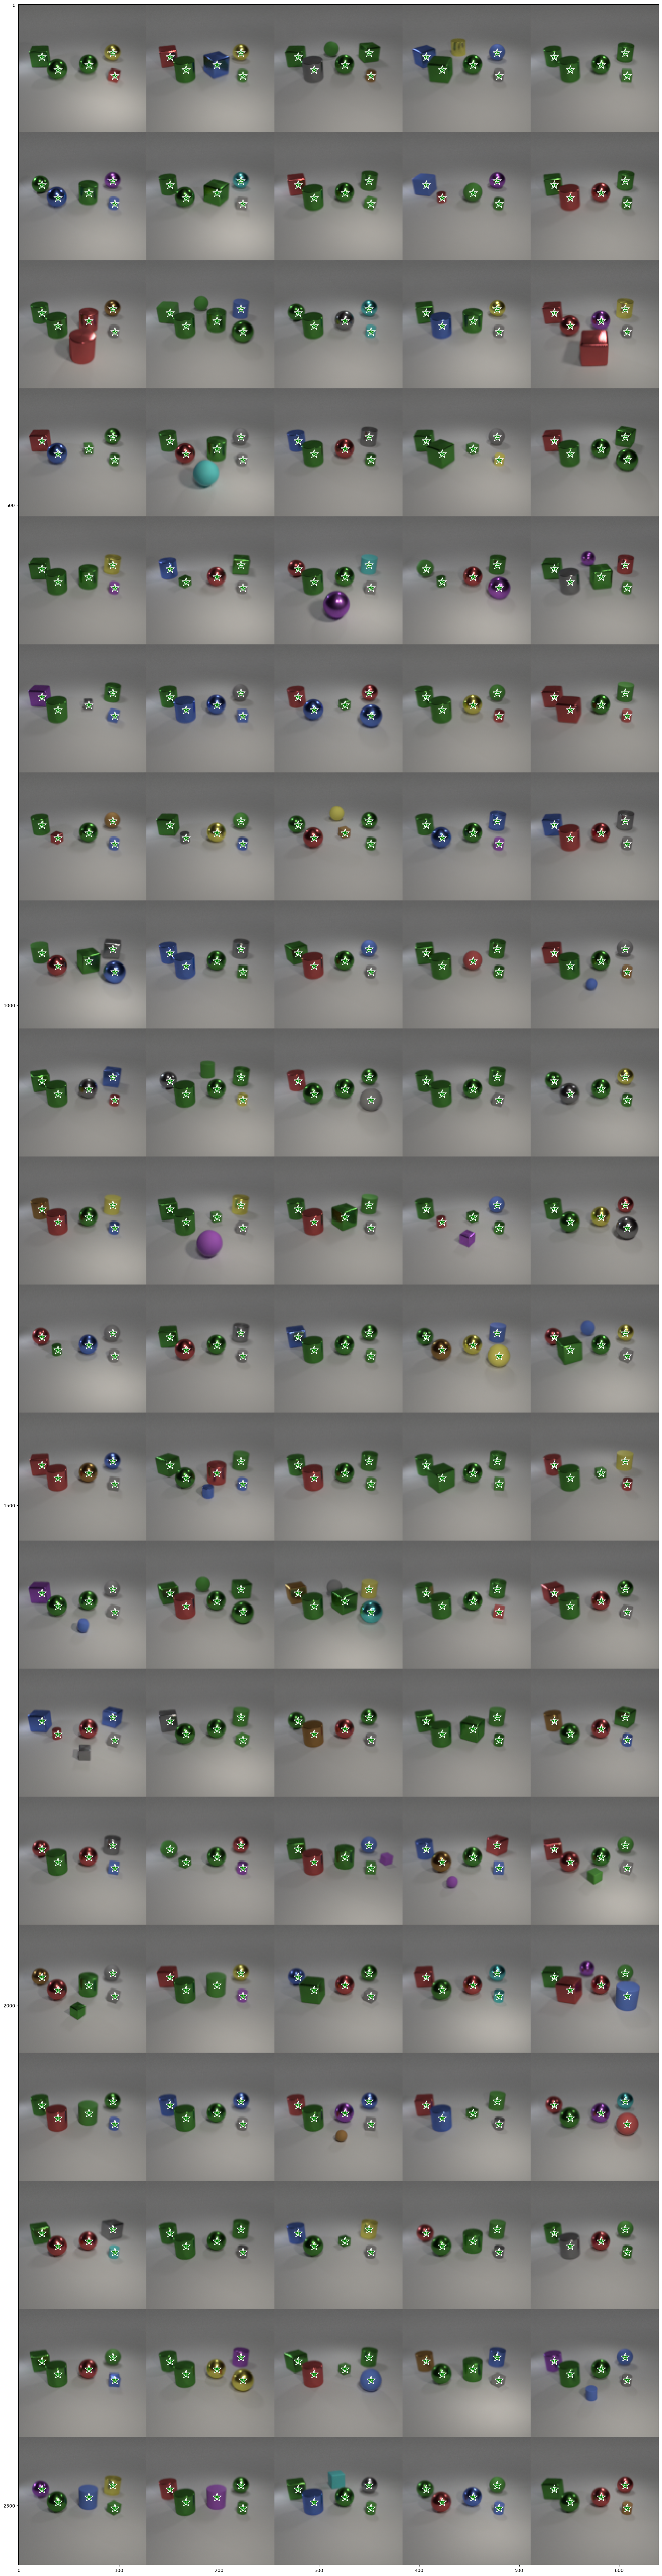

In [12]:
import baselines_clevr
from tqdm.auto import tqdm


packed_samples = []
for test_idx in range(10):

    th.manual_seed(0)
    th.cuda.manual_seed(0)

    labels, _ = dataset[test_idx]
    samples_over_time = baselines_clevr.diffusion_baseline(denoise_fn=lambda x, t: composed_model_fn(x, t, th.from_numpy(labels).to(device)),
                                                           diffusion=diffusion,
                                                           x_shape=(3, 128, 128),
                                                           eval_batch_size=100)
    save_image_for_diffusion_sample(samples_over_time, test_idx)
    packed_samples.append(th.stack(samples_over_time, dim=1))

packed_samples = th.stack(packed_samples, dim=0)
# -> (n_idx, n_sample, T+1, 3, 128, 128)

In [110]:
# th.save(packed_samples, output_dir / "packed_samples.pt")
packed_samples = th.load("runs/11-04_19_47-02_clevr_pos_5_notebook-logp/"

In [14]:
# load the labels
# successes = np.load("runs/10-30_12-00-51_clevr_pos_5_notebook-logp/sam_labels/successes.npy")
successes = np.load("runs/11-04_19_47-02_clevr_pos_5_notebook-logp/sam_labels/successes.npy")
successes = th.from_numpy(np.array(successes))

final_samples = [np.array(Image.open(f"../tiny-diffusion/ComposableDiff/output/test_clevr_pos_5000_5/sample_{idx:05d}.png")) for idx in tqdm(range(5000))]
final_samples = th.from_numpy(np.array(final_samples))
final_samples = (final_samples / 255) * 2 - 1
final_samples = final_samples.permute(0, 3, 1, 2)
final_samples = final_samples.to(device)

100%|██████████| 5000/5000 [00:01<00:00, 3001.14it/s]


In [ ]:
final_samples = packed_samples[:, :, -1, ...]

In [ ]:
packed_samples.shape

In [25]:
%%time
################ RANDOM NOISE ##################
from scripts.analyze_logp_best_of_n_on_sam_dataset import get_s1_and_s2
import wandb

run = wandb.init(project="analyze_logp",
                 name=f"{cfg.experiment_name}",
                 config=OmegaConf.to_container(cfg, resolve=True),
                 entity="rainorangelemon")

l2_distance_diff_packed = th.zeros((5000, 1, len(diffusion.timestep_map), cfg.num_constraints))
for timestep_idx, k in enumerate(diffusion.timestep_map):
    success_preds = []
    for test_idx in tqdm(range(5000)):
        th.manual_seed(0)
        th.cuda.manual_seed(0)
        
        labels, _ = dataset[test_idx]
        conditions_denoise_fn = conditions_denoise_fn_factory(model, th.tensor(labels[np.newaxis], dtype=th.float32),
                                                              batch_size=cfg.elbo.mini_batch, cfg=cfg)
    
        final_samples_per_test = final_samples[test_idx, None, ...].to(device)
        # -> (1, 3, 128, 128)
        timesteps_t = th.full((len(final_samples_per_test),), 0, dtype=th.long, device=final_samples_per_test.device)
        s1, s2 = get_s1_and_s2(diffusion.base_diffusion, t=0, k=k)
        noise = th.randn_like(final_samples_per_test[0, ...], device=final_samples_per_test.device)[None, ...]
    
        success_pred = th.ones((len(final_samples_per_test),), device=device, dtype=th.bool)
        for condition_idx in range(cfg.num_constraints):
            predicted_noise, model_variance, predicted_noise_uncond, model_variance_uncond = predict_noise(final_samples_per_test, conditions_denoise_fn[condition_idx], noise, timesteps_t, k)
            # get the L2 distance
            l2_distance = ((predicted_noise - noise).pow(2) / model_variance).sum(dim=(1, 2, 3))
            # l2_distance_uncond = ((predicted_noise_uncond - noise).pow(2) / model_variance_uncond).sum(dim=(1, 2, 3))
            l2_distance_uncond = ((0.9 * predicted_noise - noise).pow(2) / model_variance).sum(dim=(1, 2, 3))
            l2_distance_diff = l2_distance - l2_distance_uncond
            success_pred = success_pred & (l2_distance_diff < 0.)
            l2_distance_diff_packed[test_idx, :, timestep_idx, condition_idx] = l2_distance_diff
    
        if success_pred:
            success_preds.append(successes[test_idx])
    
    wandb.log({f"success_overall/gt": successes.float().mean(), 
               f"success_overall/pred": np.array(success_preds).mean()
              })

 95%|█████████▍| 4735/5000 [05:34<00:18, 14.17it/s]


KeyboardInterrupt: 

In [22]:
%%time
################ CACHED NOISE ##################
from scripts.analyze_logp_best_of_n_on_sam_dataset import get_s1_and_s2
import wandb

run = wandb.init(project="analyze_logp",
                 name=f"{cfg.experiment_name}",
                 config=OmegaConf.to_container(cfg, resolve=True),
                 entity="rainorangelemon")

l2_distance_diff_packed = th.zeros((10, 100, len(diffusion.timestep_map), cfg.num_constraints))
for timestep_idx, k in enumerate(diffusion.timestep_map):
    success_preds = []
    for test_idx in range(10):
        th.manual_seed(0)
        th.cuda.manual_seed(0)
        
        labels, _ = dataset[test_idx]
        conditions_denoise_fn = conditions_denoise_fn_factory(model, th.tensor(labels[np.newaxis], dtype=th.float32),
                                                              batch_size=cfg.mini_batch, cfg=cfg)
    
        final_samples_per_test = packed_samples[test_idx, :, -1, ...].to(device)
        # -> (100, 3, 128, 128)
        timesteps_t = th.full((len(final_samples_per_test),), 0, dtype=th.long, device=final_samples_per_test.device)
        samples_at_k = th.flip(packed_samples[test_idx, ...], dims=(1,))[:, diffusion.timestep_map.index(k)+1, ...].to(device)
        s1, s2 = get_s1_and_s2(diffusion.base_diffusion, t=0, k=k)
        noise = (samples_at_k - s1 * final_samples_per_test) / s2
    
        success_pred = th.ones((len(final_samples_per_test),), device=device, dtype=th.bool)
        for condition_idx in range(cfg.num_constraints):
            predicted_noise, model_variance, predicted_noise_uncond, model_variance_uncond = predict_noise(final_samples_per_test, conditions_denoise_fn[condition_idx], noise, timesteps_t, k)
            # get the L2 distance
            l2_distance = ((predicted_noise - noise).pow(2) / model_variance).sum(dim=(1, 2, 3))
            l2_distance_uncond = ((predicted_noise_uncond - noise).pow(2) / model_variance_uncond).sum(dim=(1, 2, 3))
            l2_distance_diff = l2_distance - l2_distance_uncond
            success_pred = success_pred & (l2_distance_diff < 0.)
            l2_distance_diff_packed[test_idx, :, timestep_idx, condition_idx] = l2_distance_diff
    
        wandb.log({f"success_{test_idx}/gt": successes[test_idx].float().mean(), 
                   f"success_{test_idx}/pred": successes[test_idx][success_pred.cpu().numpy()].float().mean()
                  })
        success_preds.append(successes[test_idx][success_pred.cpu().numpy()].flatten())
    
    wandb.log({f"success_overall/gt": successes.float().mean(), 
               f"success_overall/pred": th.concat(success_preds).float().mean()
              })

/home/rainorangelemon/Documents/tiny-diffusion/scripts/analyze_logp_best_of_n_on_sam_dataset.py:508: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="../conf")
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: rainorangelemon. Use `wandb login --relogin` to force relogin


NameError: name 'packed_samples' is not defined

# Analyze

In [70]:
for id, t, l2_distance_diff in zip(range(len(diffusion.timestep_map)), diffusion.timestep_map, th.permute(l2_distance_diff_packed, (2, 0, 1, 3))):
    print(f"index {id:02d}, timestep {t:03d}, "
          f"rejection rate {(l2_distance_diff < 0).all(dim=-1).float().mean():.3f}, "
          f"success rate {successes[(l2_distance_diff < 0).all(dim=-1).flatten()].float().mean():.2f}, "
          f"scale {l2_distance_diff.abs().mean():.2f}"
    )

index 00, timestep 000, rejection rate 0.719, success rate 0.55, scale 57103672.00
index 01, timestep 010, rejection rate 0.986, success rate 0.60, scale 1624206.75
index 02, timestep 020, rejection rate 0.985, success rate 0.60, scale 641533.69
index 03, timestep 030, rejection rate 0.987, success rate 0.60, scale 366375.44
index 04, timestep 040, rejection rate 0.991, success rate 0.60, scale 240164.11
index 05, timestep 050, rejection rate 0.992, success rate 0.60, scale 171524.73
index 06, timestep 061, rejection rate 0.988, success rate 0.60, scale 123142.19
index 07, timestep 071, rejection rate 0.992, success rate 0.60, scale 104312.42
index 08, timestep 081, rejection rate 0.993, success rate 0.60, scale 83991.76
index 09, timestep 091, rejection rate 0.988, success rate 0.60, scale 67489.48
index 10, timestep 101, rejection rate 0.984, success rate 0.60, scale 57522.38
index 11, timestep 111, rejection rate 0.977, success rate 0.60, scale 45599.83
index 12, timestep 121, rejec

In [121]:
th.save(l2_distance_diff_packed, f"runs/11-04_19_47-02_clevr_pos_5_notebook-logp/l2_distance_diff_packed.pt")

# Try Rejection Sampling

In [ ]:
import baselines_clevr
from tqdm.auto import tqdm
from torchvision.utils import save_image, make_grid


import wandb

run = wandb.init(project="rejection_sampling",
                 name=f"notebook-try",
                 config=OmegaConf.to_container(cfg, resolve=True),
                 entity="rainorangelemon")

NUM_SAMPLES_PER_TRIAL = 10

packed_samples = th.zeros((5000, 10, 3, 128, 128))
packed_energies = th.zeros((5000, cfg.num_constraints, NUM_SAMPLES_PER_TRIAL))
for test_idx in tqdm(range(5000)):

    th.manual_seed(0)
    th.cuda.manual_seed(0)

    labels, _ = dataset[test_idx]
    conditions_denoise_fn = conditions_denoise_fn_factory(model, th.tensor(labels[np.newaxis], dtype=th.float32),
                                                          batch_size=cfg.elbo.mini_batch, cfg=cfg)    
    filtered_samples, unfiltered_samples_over_time, need_to_remove_across_timesteps, energies_across_timesteps = \
    baselines_clevr.rejection_sampling_baseline(
                                composed_denoise_fn=lambda x, t: composed_model_fn(x, t, th.from_numpy(labels).to(device)),
                                unconditioned_denoise_fn=conditions_denoise_fn[-1],
                                conditions_denoise_fn=conditions_denoise_fn[:-1],
                                x_shape=(3, 128, 128),
                                noise_scheduler=diffusion,
                                num_samples_per_trial=NUM_SAMPLES_PER_TRIAL,
                                rejection_scheduler_cfg=cfg.rejection_scheduler,
                                elbo_cfg=cfg.elbo,
                                progress=False,
                                )
    packed_samples[test_idx, ...] = unfiltered_samples_over_time[-1]
    packed_energies[test_idx, ...] = th.from_numpy(np.array(list(energies_across_timesteps.values())))

    # save the figure
    if len(filtered_samples):
        # randomly pick one sample
        sample_at_final_t = filtered_samples[np.random.randint(len(filtered_samples))]
    else:
        # choose the one with minimum energy
        score = packed_energies[test_idx].sum(dim=-1)
        sample_at_final_t = unfiltered_samples_over_time[-1][score.argmin()]

    sample_at_final_t = (sample_at_final_t + 1) / 2
    grid = make_grid(sample_at_final_t, nrow=1, padding=0)
    save_image(grid, output_dir / f"sample_{test_idx:05d}.png")

    wandb.log({f"filtered_ratio": len(filtered_samples) / len(unfiltered_samples_over_time[-1]),
              })

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: rainorangelemon. Use `wandb login --relogin` to force relogin


  0%|          | 0/5000 [00:00<?, ?it/s]AUTOTUNE convolution(24x3x128x128, 192x3x3x3)
  triton_convolution_4 0.2908 ms 100.0%
  triton_convolution_6 0.3995 ms 72.8%
  triton_convolution_0 0.4206 ms 69.1%
  convolution 0.4567 ms 63.7%
  triton_convolution_5 0.5058 ms 57.5%
  triton_convolution_3 0.5847 ms 49.7%
  triton_convolution_2 0.6704 ms 43.4%
  triton_convolution_1 0.6973 ms 41.7%
SingleProcess AUTOTUNE takes 7.0473 seconds
AUTOTUNE convolution(24x192x128x128, 192x192x3x3)
  triton_convolution_11 1.8638 ms 100.0%
  convolution 1.9700 ms 94.6%
  triton_convolution_13 2.0849 ms 89.4%
  triton_convolution_8 2.1555 ms 86.5%
  triton_convolution_7 2.3777 ms 78.4%
  triton_convolution_12 2.4297 ms 76.7%
  triton_convolution_10 2.4863 ms 75.0%
  triton_convolution_9 9.2938 ms 20.1%
SingleProcess AUTOTUNE takes 6.9704 seconds
AUTOTUNE mm(24x192, 192x768)
  triton_mm_18 0.0051 ms 100.0%
  triton_mm_19 0.0051 ms 100.0%
  triton_mm_20 0.0051 ms 100.0%
  triton_mm_22 0.0051 ms 100.0%
  trito

In [11]:
# Save the packed samples
packed_samples = (packed_samples + 1) * 127.5
# convert packed samples to uint8 to save space
packed_samples = packed_samples.round().to(dtype=th.uint8)
th.save(packed_samples, output_dir / "packed_samples.pt")
th.save(packed_energies, output_dir / "packed_energies.pt")

In [20]:
(packed_energies > 0).any(dim=1).all(dim=-1).float().mean()

tensor(0.1912)

In [62]:
successes = np.load("runs/11-04_19_47-02_clevr_pos_5_notebook-logp/sam_labels/successes.npy")
successes = th.from_numpy(np.array(successes))

In [65]:
successes_resampled = np.load("runs/11-05_14-52-32_clevr_pos_5_notebook-logp/test_clevr_pos_5000_5/sam_labels.npy")
successes_resampled = th.from_numpy(np.array(successes_resampled))

In [75]:
use_best_of_n = (packed_energies[:100] > 0).any(dim=1).all(dim=1)
successes_resampled[~use_best_of_n].float().mean(), successes_resampled[use_best_of_n].float().mean()

(tensor(0.9620), tensor(0.5238))